### Topic Modeling: Demand for Cybersecurity Professionals  

In [14]:
import pandas as pd 
import numpy as np
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#### Data Preprocessing 
Indeed Data 

In [15]:
df = pd.read_csv("C:/Users/hanna/Scape-Save-DAEN690/Datasets/indeed_cleaned.csv.gz")

In [16]:
#Remove duplicate postings if the job title, description and location are the same 
df.drop_duplicates(subset=['job_title', 'description_text', 'location'], inplace=True)

In [17]:
#Set to lower case so capitalized titles don't get counted separately
df['job_title'] = df['job_title'].apply(lambda x: str(x).lower())
#Set to lower case for job descriptions 
df['description_text'] = df['description_text'].apply(lambda x: str(x).lower())
#remove numerical values from job description
df['description_text'] = df['description_text'].str.replace('\d+', '')
#remove links from job description 
df['description_text'] = df['description_text'].str.replace('http\S+|www.\S+', '', case=False)



In [18]:
#Create function to categorize role types 

def role_type(x):
    if 'lead' in x:
        return 'senior'
    elif 'senior' in x:
        return 'senior'
    elif 'sr' in x:
        return 'senior'
    elif 'chief' in x:
        return 'upper mgmt'
    elif 'manager' in x:
        return 'upper mgmt'
    elif 'principal' in x:
        return 'upper mgmt'
    elif 'junior' in x:
        return 'entry-level'
    elif 'jr' in x:
        return 'entry-level'
    elif 'entry-level' in x:
        return 'entry-level'
    elif 'entry level' in x:
        return 'entry-level'
    elif 'professor' in x: 
        return 'academia'
    else:
        return 'other'
    
df['role_type'] = df['job_title'].apply(role_type)

#Can be used for visualizations 
job_df = df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]


In [19]:
#Comparing job descriptions using cosine similarity will help remove job descriptions that are almost identical with additional word difference 
#Helps reduce processing time of the model 

corpus= df['description_text']

count_vect = CountVectorizer()

x_counts = count_vect.fit_transform(corpus)

cos_df = pd.DataFrame(cosine_similarity(x_counts))
 
i, j = np.indices(cos_df.shape).reshape(2, -1)

cos_values = cos_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'score':cos_values})

#similarity score >0.99 indicates that the job descriptions are very similar with slight variations in wordings
cos_rem = cos_sim_df[(cos_sim_df['score']>0.99)&(i!=j)]

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

#Drop rows with >0.99 similarity score from original dataframe
df = df[~df.index.isin(drop_rows)]
df = df.reset_index()
df.drop(columns={'index'}, inplace=True)

CareerOneStop Data

In [20]:
cos_df = pd.read_excel("C:/Users/hanna/Scape-Save-DAEN690/Datasets//careeronestop_data.xlsx") 

In [21]:
cos_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)
#Set to lower case so capitalized titles don't get counted separately
cos_df['job_title'] = cos_df['job_title'].apply(lambda x: str(x).lower())
cos_df['description'] = cos_df['description'].apply(lambda x: str(x).lower())
#remove links from job description 
cos_df['description'] = cos_df['description'].str.replace('http\S+|www.\S+', '', case=False)

In [22]:
#Set to lower case so capitalized titles don't get counted separately
cos_df['job_title'] = cos_df['job_title'].apply(lambda x: x.lower())
#Set to lower case for job descriptions 
cos_df['description'] = cos_df['description'].apply(lambda x: str(x).lower())
#remove numerical values from job description
cos_df['description'] = cos_df['description'].str.replace('\d+', '')

In [23]:
#apply function to add job roles 
cos_df['role_type'] = cos_df['job_title'].apply(role_type)

job_df = cos_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]

In [24]:
cos_df.shape

(8920, 8)

In [25]:
corpus= cos_df['description']

count_vect = CountVectorizer()

x_count_cos = count_vect.fit_transform(corpus.values.astype('U'))

cosi_df = pd.DataFrame(cosine_similarity(x_count_cos))

i, j = np.indices(cosi_df.shape).reshape(2, -1)

cos_values = cosi_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'score':cos_values})

#similarity score >0.99 indicates that the job descriptions are very similar with slight variations in wordings 
cos_rem = cos_sim_df[(cos_sim_df['score']>0.99)&(i!=j)]

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

cos_df = cos_df[~cos_df.index.isin(drop_rows)]
cos_df = cos_df.reset_index()
cos_df.drop(columns={'index'}, inplace=True)

#### BERTopic Algorithm

In [26]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
# ngram_range set to 2 so the topics extracted can also be 'two-words' instead of one 
vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - Fine-tune topic representations with 
# reduces redundacy and improve diversity of keywords using MMR 
representation_model = MaximalMarginalRelevance(0.4)

topic_model = BERTopic(
  embedding_model=embedding_model, # Step 1: Embedding        
  umap_model=umap_model, # Step 2: Dimensionality reduction                   
  hdbscan_model=hdbscan_model, # Step 3: Clustering              
  vectorizer_model=vectorizer_model, # Step 4: Tokenizer 
  top_n_words=8,         
  ctfidf_model=ctfidf_model, # Step 5: Weighting scheme                
  representation_model=representation_model, nr_topics="auto") # Step 6: Fine-tune topic representation 

topic_model_in = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model) 

In [27]:
#CareerOneStop model
topic, prob = topic_model.fit_transform(cos_df['description'].values.astype('U'))

In [28]:
#Indeed Model
topic_in, prob_in = topic_model_in.fit_transform(df['description_text']) 


In [29]:
#before topic reduction: model contains 242 topics 
topic_model.get_topic_freq()

,Topic,Count
0,-1,1296
1,0,532
2,1,188
3,2,79
4,3,76
...,...,...
113,112,11
114,113,11
115,114,11
116,115,11


In [30]:
topic_model_in.get_topic_freq()

,Topic,Count
0,-1,3081
1,0,156
2,1,125
3,2,105
4,3,88
...,...,...
211,210,10
212,211,10
213,212,10
214,213,10


In [31]:
#topic reduction model, reduce topic count to 50 
# topic_model.reduce_topics(cos_df['description'].values.astype('U'), nr_topics=50)
# topics = topic_model.topics_

In [32]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1296,-1_experience_cybersecurity_management_risk
1,0,532,0_experience_systems_information security_cybe...
2,1,188,1_ctg_cerner millennium_build_cerner security
3,2,79,2_ey_data_clients_data protection
4,3,76,3_apria healthcare_information security_work_v...
...,...,...,...
113,112,11,112_axp_amex_atwell_express equal
114,113,11,113_devsecops_ci cd_devops_build
115,114,11,114_faculty_students_cybersecurity_engineering
116,115,11,115_resiliency_wells fargo_cyber resiliency_so...


In [33]:
topic_model_in.get_topic_info()

,Topic,Count,Name
0,-1,3081,-1_experience_cybersecurity_management_support
1,0,156,0_network security_cisco_routing_networking
2,1,125,1_information security_security analyst_manage...
3,2,105,2_dod_rmf_security officer_requirements
4,3,88,3_project_managed services_project manager_pro...
...,...,...,...
211,210,10,210_rmc hiring_rmc employees_applicant_employe...
212,211,10,211_incident response_threat_dapper_mckesson
213,212,10,212_sce_work mode_energy_california edison
214,213,10,213_cyber security_business analyst_requiremen...


In [34]:
#model with careeronestop data
topic_model.visualize_barchart(top_n_topics=5)

In [35]:
#model with indeed data 
topic_model_in.visualize_barchart(top_n_topics=5)

In [36]:
freq = topic_model_in.get_topic_info() 
print(freq)

     Topic  Count                                               Name
0       -1   3081     -1_experience_cybersecurity_management_support
1        0    156        0_network security_cisco_routing_networking
2        1    125  1_information security_security analyst_manage...
3        2    105            2_dod_rmf_security officer_requirements
4        3     88  3_project_managed services_project manager_pro...
..     ...    ...                                                ...
211    210     10  210_rmc hiring_rmc employees_applicant_employe...
212    211     10       211_incident response_threat_dapper_mckesson
213    212     10         212_sce_work mode_energy_california edison
214    213     10  213_cyber security_business analyst_requiremen...
215    214     10  214_giac certified_cyber intelligence_intellig...

[216 rows x 3 columns]


In [37]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1296,-1_experience_cybersecurity_management_risk
1,0,532,0_experience_systems_information security_cybe...
2,1,188,1_ctg_cerner millennium_build_cerner security
3,2,79,2_ey_data_clients_data protection
4,3,76,3_apria healthcare_information security_work_v...
...,...,...,...
113,112,11,112_axp_amex_atwell_express equal
114,113,11,113_devsecops_ci cd_devops_build
115,114,11,114_faculty_students_cybersecurity_engineering
116,115,11,115_resiliency_wells fargo_cyber resiliency_so...


In [38]:
#keywords present in our top topics 
topic_model_in.get_topic(freq.iloc[2]["Topic"])

[('information security', 0.009379781180078135),
 ('security analyst', 0.008890453551134882),
 ('management', 0.0033794665609993423),
 ('procedures', 0.0032676261280650864),
 ('experience', 0.0032602443583307026),
 ('skills', 0.003193245300752199),
 ('vulnerability', 0.0030831893789207733),
 ('incident response', 0.002830149444263032),
 ('data', 0.0026071676329734424),
 ('compliance', 0.002587741470035145)]

In [39]:
#10 most representative terms for each top topic
top_terms = topic_model.get_topics()

#Top terms for top 5 topics
for key, value in top_terms.items():
    if key in [0, 1, 2, 3, 4]:
        print(f"{key}: {value}\n")

0: [('experience', 0.005761932864260122), ('systems', 0.005183836598390121), ('information security', 0.004653896123875117), ('cybersecurity', 0.00448780330136401), ('management', 0.004028679074220716), ('years', 0.003963645109443787), ('requirements', 0.0037500452474076747), ('skills', 0.0032892082734648095)]

1: [('ctg', 0.04102844952347006), ('cerner millennium', 0.019718642962100658), ('build', 0.012918266604758522), ('cerner security', 0.011524579812245776), ('millennium security', 0.011524579812245776), ('millennium position', 0.011524579812245776), ('security application', 0.010648687107595922), ('transfer', 0.009787313402988995)]

2: [('ey', 0.027324951294842376), ('data', 0.015585249322006908), ('clients', 0.012800612868467995), ('data protection', 0.012213190301229403), ('data classification', 0.007624568435174987), ('develop', 0.007280043077172762), ('working world', 0.007246513927676687), ('information security', 0.006465362328442876)]

3: [('apria healthcare', 0.0120692822

In [40]:
#Add the topic for each record in the dataframe - CareerOneStop & Indeed Data
cos_df['topic'] = topic
df['topic_in'] = topic_in

In [41]:
#Group all keywords with a certain topic
topic_0 = cos_df[cos_df['topic'] == 0].groupby('keyword')['keyword'].count()
topic_1 = cos_df[cos_df['topic'] == 1].groupby('keyword')['keyword'].count()
topic_2 = cos_df[cos_df['topic'] == 2].groupby('keyword')['keyword'].count()
topic_3 = cos_df[cos_df['topic'] == 3].groupby('keyword')['keyword'].count()
topic_4 = cos_df[cos_df['topic'] == 4].groupby('keyword')['keyword'].count()

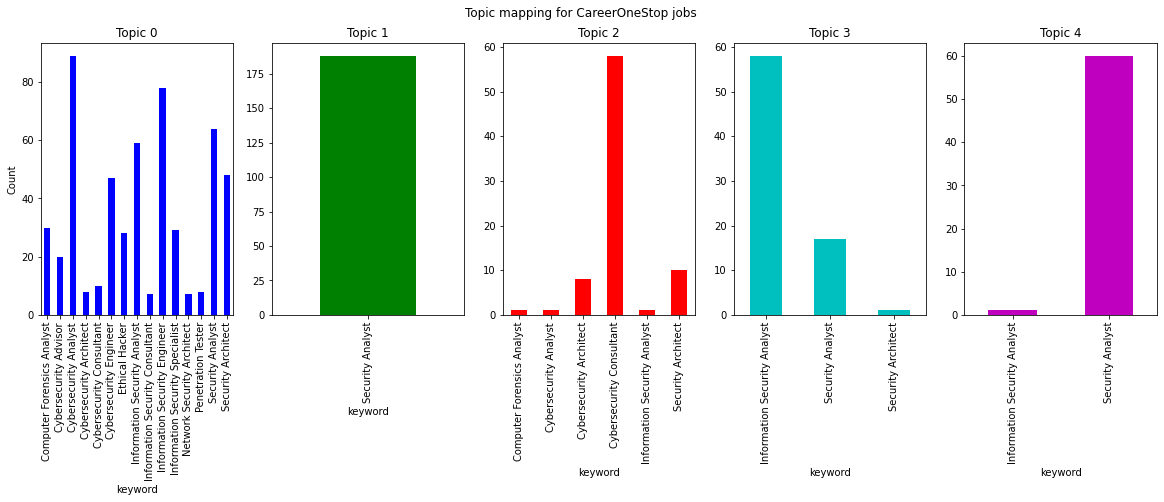

In [42]:
#Barplots showing the job families for each topic
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# plot each series on a different subplot
topic_0.plot.bar(ax=axs[0], color='b')
topic_1.plot.bar(ax=axs[1], color='g')
topic_2.plot.bar(ax=axs[2], color='r')
topic_3.plot.bar(ax=axs[3], color='c')
topic_4.plot.bar(ax=axs[4], color='m')

# set titles and labels for each subplot
axs[0].set_title('Topic 0')
axs[1].set_title('Topic 1')
axs[2].set_title('Topic 2')
axs[3].set_title('Topic 3')
axs[4].set_title('Topic 4')
axs[0].set_ylabel('Count')


# set a title for the figure
fig.suptitle('Topic mapping for CareerOneStop jobs')

# display the plot
plt.show()